# Install Transformer Library

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.8 MB 5.4 MB/s 
     |████████████████████████████████| 52 kB 1.6 MB/s 
     |████████████████████████████████| 895 kB 40.7 MB/s 
     |████████████████████████████████| 3.3 MB 35.8 MB/s 
     |████████████████████████████████| 636 kB 32.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Import required libraries

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

# Load Dataset

Load "i" and "we" datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_i = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Fairness/data/i_masked_v3.csv" ,encoding='utf-8', header=None)
df_i.head()

,0,1
0,0,On the appointed day a number of representativ...
1,0,"""The People"" remarked that this one error wipe..."
2,0,"Therefore, liquidated three of his brothers an..."
3,0,"After she presented ""The Super Saturday Show"" ..."
4,0,After redshirting his freshman year at Oregon ...


In [ ]:
df_we = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Fairness/data/we_masked_v3.csv",header=None)
df_we.head()

,0,1
0,1,The conquered areas that were under the rule o...
1,1,"In this case, the operator formula_99 is Hermi..."
2,1,"A shell threw down the flag, which was raised ..."
3,1,"Why should he live in a Palace?,And why should..."
4,1,"As he had explained to Hashimi before, ""the re..."


In [ ]:
frames = [df_i,df_we]

df = pd.concat(frames)
df.head()

,0,1
0,0,On the appointed day a number of representativ...
1,0,"""The People"" remarked that this one error wipe..."
2,0,"Therefore, liquidated three of his brothers an..."
3,0,"After she presented ""The Super Saturday Show"" ..."
4,0,After redshirting his freshman year at Oregon ...


In [ ]:
df.columns = ["label", "text"]

In [ ]:
df.head()

,label,text
0,0,On the appointed day a number of representativ...
1,0,"""The People"" remarked that this one error wipe..."
2,0,"Therefore, liquidated three of his brothers an..."
3,0,"After she presented ""The Super Saturday Show"" ..."
4,0,After redshirting his freshman year at Oregon ...


In [ ]:
df.shape

(6002, 2)

In [ ]:
# check class distribution
df['label'].value_counts(normalize = True)

1    0.5
0    0.5
Name: label, dtype: float64

In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.4, 
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

Load "They(p)" and "they(S)" data

In [ ]:
df_they = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Fairness/data/they_annotation.csv",header=None)
df_they.head()

,0,1
0,1,"In addition, the association played a role in ..."
1,1,Greene won the NFL Defensive Player of the Yea...
2,1,"Brown was replaced by Farrar, a native of LaGr..."
3,1,Wilson also secured the organisation's current...
4,1,"As regards the recognition of a prophet, Zoroa..."


In [ ]:
df_sin_they = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Fairness/data/they_sin_annotation1.csv",encoding='cp1252',header=None)
df_sin_they.head()

,0,1
0,0,Anzoategui began acting in the Los Angeles the...
1,0,Ariela Barer started acting at the age of thre...
2,0,"Musician Kathleen Hanna, writing for Artforum,..."
3,0,"While attending the University of Akron, Butch..."
4,0,Del Barrio attended Crossroads School in Calif...


In [ ]:
frames = [df_they,df_sin_they]

df_they_all = pd.concat(frames)
df_they_all.head()

,0,1
0,1,"In addition, the association played a role in ..."
1,1,Greene won the NFL Defensive Player of the Yea...
2,1,"Brown was replaced by Farrar, a native of LaGr..."
3,1,Wilson also secured the organisation's current...
4,1,"As regards the recognition of a prophet, Zoroa..."


In [ ]:
df_they_all.columns = ["label", "text"]

In [ ]:
#replacing "they" with [MASK]
import re
for i in range(len(df_they_all)):

  new_sen=df_they_all['text'].iloc[i]

  tokens={"they":"[MASK]","They":"[MASK]"}

  regex=re.compile("|".join([r"\b{}\b".format(t) for t in tokens]))

  new_sen=regex.sub(lambda m: tokens[m.group(0)], new_sen.rstrip())

  df_they_all['text'].iloc[i]=new_sen

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
test2_text = df_they_all['text']
test2_labels = df_they_all['label']

In [ ]:
train2_text, test2_text, train2_labels, test2_labels = train_test_split(df_they_all['text'], df_they_all['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df_they_all['label'])

# Import BERT Model and BERT Tokenizer

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased',)

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

# Tokenization

In [ ]:
max_seq_len = 256

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
tokens_test2 = tokenizer.batch_encode_plus(
    test2_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# tokenize and encode sequences in the training set
tokens_train2 = tokenizer.batch_encode_plus(
    train2_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)


# tokenize and encode sequences in the test set
tokens_test2 = tokenizer.batch_encode_plus(
    test2_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Convert Integer Sequences to Tensors

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
test2_seq = torch.tensor(tokens_test2['input_ids'])
test2_mask = torch.tensor(tokens_test2['attention_mask'])
test2_y = torch.tensor(test2_labels.tolist())

In [ ]:
# for train set
train2_seq = torch.tensor(tokens_train2['input_ids'])
train2_mask = torch.tensor(tokens_train2['attention_mask'])
train2_y = torch.tensor(train2_labels.tolist())

# for test set
test2_seq = torch.tensor(tokens_test2['input_ids'])
test2_mask = torch.tensor(tokens_test2['attention_mask'])
test2_y = torch.tensor(test2_labels.tolist())

# Create DataLoaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 64

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 64

# wrap tensors
train2_data = TensorDataset(train2_seq, train2_mask, train2_y)

# sampler for sampling the data during training
train2_sampler = RandomSampler(train2_data)

# dataLoader for train set
train2_dataloader = DataLoader(train2_data, sampler=train2_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,350)

      self.fc3 = nn.Linear(350,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      cls_hs = self.bert(sent_id, attention_mask=mask).pooler_output

      #print(cls_hs.shape)
      x = self.fc1(cls_hs)
      #print(x.shape)
      x = self.relu(x)
    
      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      x = self.relu(x)
    
      x = self.dropout(x)
      x = self.fc3(x)
      #print(x.shape)
      # apply softmax activation
      x = self.softmax(x)
      #print(x.shape)
      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 5e-5)

# Find Class Weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[1.00027778 0.99972238]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 60

# Fine-Tune BERT

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    #print('pred',preds)
    #print('labels',labels)
    #print(preds.shape)
    #print(labels.shape)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# set initial loss to infinite
epochs=20
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 20
  Batch    50  of     57.

Evaluating...

Training Loss: 0.688
Validation Loss: 0.679

 Epoch 2 / 20
  Batch    50  of     57.

Evaluating...

Training Loss: 0.671
Validation Loss: 0.656

 Epoch 3 / 20
  Batch    50  of     57.

Evaluating...

Training Loss: 0.646
Validation Loss: 0.627

 Epoch 4 / 20
  Batch    50  of     57.

Evaluating...

Training Loss: 0.620
Validation Loss: 0.603

 Epoch 5 / 20
  Batch    50  of     57.

Evaluating...

Training Loss: 0.605
Validation Loss: 0.593

 Epoch 6 / 20
  Batch    50  of     57.

Evaluating...

Training Loss: 0.600
Validation Loss: 0.588

 Epoch 7 / 20
  Batch    50  of     57.

Evaluating...

Training Loss: 0.599
Validation Loss: 0.585

 Epoch 8 / 20
  Batch    50  of     57.

Evaluating...

Training Loss: 0.589
Validation Loss: 0.580

 Epoch 9 / 20
  Batch    50  of     57.

Evaluating...

Training Loss: 0.577
Validation Loss: 0.575

 Epoch 10 / 20
  Batch    50  of     57.

Evaluating...

Training Loss: 0.573
Validation L

loading the best model with lowest val loss.

In [ ]:
#load weights of best model
path = '/content/saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

More training on "they(p)" vs "they(S)" data

In [ ]:
optimizer = AdamW(model.parameters(), lr = 1e-5)

In [ ]:
# function to train the model
def train2():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train2_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train2_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    #print('pred',preds)
    #print('labels',labels)
    #print(preds.shape)
    #print(labels.shape)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train2_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# set initial loss to infinite
epochs=10
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train2_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train2_loss, _ = train2()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        #torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train2_losses.append(train2_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train2_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10

Evaluating...

Training Loss: 0.733
Validation Loss: 0.552

 Epoch 2 / 10

Evaluating...

Training Loss: 0.722
Validation Loss: 0.556

 Epoch 3 / 10

Evaluating...

Training Loss: 0.643
Validation Loss: 0.561

 Epoch 4 / 10

Evaluating...

Training Loss: 0.593
Validation Loss: 0.567

 Epoch 5 / 10

Evaluating...

Training Loss: 0.564
Validation Loss: 0.574

 Epoch 6 / 10

Evaluating...

Training Loss: 0.558
Validation Loss: 0.581

 Epoch 7 / 10

Evaluating...

Training Loss: 0.545
Validation Loss: 0.588

 Epoch 8 / 10

Evaluating...

Training Loss: 0.516
Validation Loss: 0.595

 Epoch 9 / 10

Evaluating...

Training Loss: 0.506
Validation Loss: 0.604

 Epoch 10 / 10

Evaluating...

Training Loss: 0.468
Validation Loss: 0.613


# Get Predictions for Test Data

In [ ]:
with torch.no_grad():
  preds = model(test2_seq.to(device), test2_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.66      0.75      0.71       601
           1       0.71      0.62      0.66       600

    accuracy                           0.69      1201
   macro avg       0.69      0.69      0.68      1201
weighted avg       0.69      0.69      0.68      1201



Test embedding

In [ ]:
df_emb_p=df_they.sample(50)
df_emb_p.columns = ["label", "text"]
df_emb_p.head()

,label,text
97,1,The Turkish international later added another ...
133,1,"When Beatrice d'Este visited Venice in 1493, a..."
29,1,In the meantime the Reparations Commission had...
109,1,The city remained unoccupied throughout the wa...
23,1,Scans for extraterrestrial life prove inconclu...


In [ ]:
import re
for i in range(50):

  new_sen=df_emb_p['text'].iloc[i]

  tokens={"they":"[MASK]","They":"[MASK]"}

  regex=re.compile("|".join([r"\b{}\b".format(t) for t in tokens]))

  new_sen=regex.sub(lambda m: tokens[m.group(0)], new_sen.rstrip())

  df_emb_p['text'].iloc[i]=new_sen

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
df_emb_s=df_sin_they.sample(50)
df_emb_s.columns = ["label", "text"]
df_emb_s.head()

,label,text
55,0,Miller attended Middle East Film and Comic Con...
63,0,"The drag house Haus of Aja, based in Bedford–S..."
81,0,Gingrich has guest-starred on the television s...
36,0,"In 2015, Miller co-starred in the drama The St..."
82,0,Their dad is Austrian.[3] They have three sibl...


In [ ]:
import re
for i in range(50):

  new_sen=df_emb_s['text'].iloc[i]

  tokens={"they":"[MASK]","They":"[MASK]"}

  regex=re.compile("|".join([r"\b{}\b".format(t) for t in tokens]))

  new_sen=regex.sub(lambda m: tokens[m.group(0)], new_sen.rstrip())

  df_emb_s['text'].iloc[i]=new_sen

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
text_p=df_emb_p.text
print(text_p.to_list())
text_s=df_emb_s.text
print(text_s.to_list())

['The Turkish international later added another goal in the 52nd minute to give Montpellier a 2–0 lead.,.Lille drew one goal closer following a strike from Eden Hazard in the 67th minute.,."Despite constant pressure from Lille, the hosts were able to hold onto its 2–1 advantage to progress to the semi-finals where [MASK] faced the defending Coupe de France champions Paris Saint-Germain.",', 'When Beatrice d\'Este visited Venice in 1493, a regatta was held in which fifty peasant women competed.,."There were professional women rowers, referred to as ""Roddarmadam"", managing and dominating the water ferry in the archipelago of the Swedish capital of Stockholm from the 15th-century up until the late 19th-century.Women’s rowing in modern times can be traced back to the early 19th century, and an image of a women’s double scull race made the cover of Harper’s Weekly in 1870 .",."In 1892 four young women (Zulette Lamb and Lena, Agnes, and Caroline Polhamus) started ZLAC Rowing Club in San Di

In [ ]:
text_p=text_p.to_list()
text_s=text_s.to_list()

In [ ]:
emb=[]
for i in range(len(text_p)):
  text5=[]
  text5.append(text_p[i])

  tokens_test = tokenizer.batch_encode_plus(
      text5,
      max_length = 256,
      pad_to_max_length=True,
      truncation=True,
      return_token_type_ids=False
  )

  test_seq = torch.tensor(tokens_test['input_ids'])
  test_mask = torch.tensor(tokens_test['attention_mask'])
  #test_y = torch.tensor(test_labels.tolist())

  for j in range(256):
    if test_seq[0][254-j]==103:
      ind=255-j
      break

  model.eval()
  with torch.no_grad():
      preds = model.bert(test_seq.to(device), test_mask.to(device))
  
  emb.append(preds.last_hidden_state[0][ind].tolist())

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
for i in range(len(text_s)):
  text5=[]
  text5.append(text_s[i])

  tokens_test = tokenizer.batch_encode_plus(
      text5,
      max_length = 256,
      pad_to_max_length=True,
      truncation=True,
      return_token_type_ids=False
  )

  test_seq = torch.tensor(tokens_test['input_ids'])
  test_mask = torch.tensor(tokens_test['attention_mask'])
  #test_y = torch.tensor(test_labels.tolist())

  for j in range(256):
    if test_seq[0][254-j]==103:
      ind=255-j
      break

  model.eval()
  with torch.no_grad():
      preds = model.bert(test_seq.to(device), test_mask.to(device))
  
  emb.append(preds.last_hidden_state[0][ind].tolist())

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
labels=[]
for i in range(100):
  if i<=49:
    labels.append('They (Plural)')
  else:
    labels.append('They (Singular)')

In [ ]:
te=['[MASK]']

In [ ]:
import numpy as np
mat = np.matrix([x for x in emb])

In [ ]:
from sklearn.decomposition import PCA
#X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
model1 = PCA(n_components=2)
low_dim_data = model1.fit_transform(mat)
print('Lower dim data has shape',low_dim_data.shape)

Lower dim data has shape (100, 2)


[Text(0, 0.5, '')]

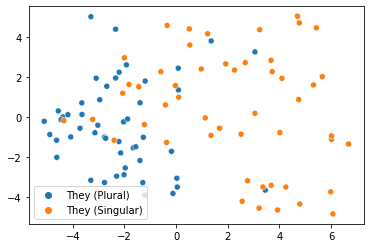

In [ ]:
import seaborn as sns
tsne_df =  pd.DataFrame(low_dim_data, labels)
ax =  sns.scatterplot(data=tsne_df, x=0, y=1, hue=tsne_df.index)
#ax.set_title('PCA, colored by pronoun type')
ax.set(xlabel=None)
ax.set(ylabel=None)

BERT w/o training

In [ ]:
import numpy as np
mat = np.matrix([x for x in emb])

In [ ]:
from sklearn.manifold import TSNE
model1 = TSNE(n_components=2)
low_dim_data = model1.fit_transform(mat)
print('Lower dim data has shape',low_dim_data.shape)

Lower dim data has shape (100, 2)


Text(0.5, 1.0, 'T-SNE BERT Embeddings, colored by Emotion')

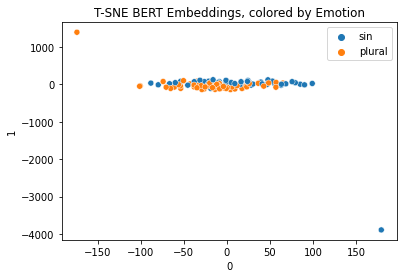

In [ ]:
import seaborn as sns
tsne_df =  pd.DataFrame(low_dim_data, labels)
ax =  sns.scatterplot(data=tsne_df, x=0, y=1, hue=tsne_df.index)
ax.set_title('T-SNE BERT Embeddings, colored by Emotion')